# Evaluation using QCB chemicals (small)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from os.path import exists

sys.path.append('../..')

In [3]:
import pylab as plt
import pandas as pd
import numpy as np
from loguru import logger
import seaborn as sns

from stable_baselines3 import DQN

In [4]:
from vimms.Common import POSITIVE, set_log_level_warning, load_obj, save_obj
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler, GaussianChromatogramSampler, UniformMZFormulaSampler, \
    MZMLFormulaSampler, MZMLRTandIntensitySampler, MZMLChromatogramSampler
from vimms.Noise import UniformSpikeNoise
from vimms.Evaluation import evaluate_real
from vimms.Chemicals import ChemicalMixtureFromMZML
from vimms.Roi import RoiBuilderParams, SmartRoiParams

from mass_spec_utils.data_import.mzmine import load_picked_boxes

from vimms_gym.env import DDAEnv
from vimms_gym.chemicals import generate_chemicals
from vimms_gym.evaluation import evaluate, run_method
from vimms_gym.common import METHOD_RANDOM, METHOD_FULLSCAN, METHOD_TOPN, METHOD_DQN, METHOD_DQN_COV, METHOD_DQN_INT

In [5]:
set_log_level_warning()

1

# 1. Parameters

Parameters that will be used throughout this notebook. Should be the same as the training ones.

Chemical generation parameters

In [6]:
n_chemicals = (20, 50)
mz_range = (100, 110)
rt_range = (400, 500)
intensity_range = (1E4, 1E20)

In [7]:
n_eval_episodes = 30
env_name = 'DDAEnv'
intensity_threshold = 0.5

Evaluation parameters

In [8]:
env_name = 'DDAEnv'
intensity_threshold = 0.5
max_peaks = 100
in_dir = 'results'
out_dir = 'evaluation'
methods = [
    METHOD_RANDOM,
    METHOD_DQN_COV,
    METHOD_DQN,    
    METHOD_DQN_INT,
    METHOD_TOPN,
]

In [9]:
# topN parameters
topN_N = 10
topN_rt_tol = 15
min_ms1_intensity = 5000

# smartroi parameters
alpha = 2
beta = 0.1
smartroi_N = topN_N
smartroi_dew = topN_rt_tol

# weighteddew parameters
t0 = 3
t1 = 120
weighteddew_N = 10

Environment parameters

In [10]:
isolation_window = 0.7
rt_tol = 120
mz_tol = 10
ionisation_mode = POSITIVE

enable_spike_noise = True
noise_density = 0.1
noise_max_val = 1E3

In [11]:
params = {
    'chemical_creator': {
        'mz_range': mz_range,
        'rt_range': rt_range,
        'intensity_range': intensity_range,
        'n_chemicals': n_chemicals,
        'mz_sampler': None,
        'ri_sampler': None,
        'cr_sampler': None,
    },
    'noise': {
        'enable_spike_noise': enable_spike_noise,
        'noise_density': noise_density,
        'noise_max_val': noise_max_val,
        'mz_range': mz_range
    },
    'env': {
        'ionisation_mode': ionisation_mode,
        'rt_range': rt_range,
        'isolation_window': isolation_window,
        'mz_tol': mz_tol,
        'rt_tol': rt_tol,
    }
}

## Generate chemical sets for evaluation

In [12]:
fname = 'QCB_chems_small.p'
found = exists(fname)
if found:
    chem_list = load_obj(fname)
    for chems in chem_list:
        print(len(chems))

28
22
45
28
20
38
34
21
37
45
36
46
49
24
32
42
25
34
44
37
23
40
43
37
27
32
34
26
28
34


Generate new chemicals if not found

In [13]:
if not found:
    repeat = 30
    logger.warning('Generating chemicals')
    min_mz = mz_range[0]
    max_mz = mz_range[1]
    min_rt = rt_range[0]
    max_rt = rt_range[1]
    min_log_intensity = np.log(intensity_range[0])
    max_log_intensity = np.log(intensity_range[1])
    
    mzml_filename = '../fullscan_QCB.mzML'
    logger.info('Creating samplers from %s' % mzml_filename)
    mz_sampler = MZMLFormulaSampler(mzml_filename, min_mz=min_mz, max_mz=max_mz)
    ri_sampler = MZMLRTandIntensitySampler(mzml_filename, min_rt=min_rt, max_rt=max_rt,
                                           min_log_intensity=min_log_intensity,
                                           max_log_intensity=max_log_intensity)
    
    # roi_params = RoiBuilderParams(min_roi_length=3, at_least_one_point_above=1000)
    # cr_sampler = MZMLChromatogramSampler(mzml_filename, roi_params=roi_params)
    cr_sampler = GaussianChromatogramSampler()
    
    chemical_creator_params = {
        'mz_range': mz_range,
        'rt_range': rt_range,
        'intensity_range': intensity_range,
        'n_chemicals': n_chemicals,
        'mz_sampler': mz_sampler,
        'ri_sampler': ri_sampler,
        'cr_sampler': cr_sampler
    }

    chem_list = []
    for i in range(repeat):
        chems = generate_chemicals(chemical_creator_params)
        print(len(chems))
        chem_list.append(chems)
        
    save_obj(chem_list, fname)

In [14]:
chem_list = chem_list[0:n_eval_episodes]
len(chem_list)

30

# 2. Evaluation

In [15]:
method_eval_results = {}
for method in methods:

    N = 0
    effective_rt_tol = rt_tol
    copy_params = dict(params)        
    copy_params['env']['rt_tol'] = effective_rt_tol
    
    custom_objects = {
        "learning_rate": 0.0,
        "lr_schedule": lambda _: 0.0,
        "clip_range": lambda _: 0.0,
    }    
    
    if method == METHOD_DQN_COV:
        model_dir = '%s_%.2f' % (in_dir, 0.75)
        fname = os.path.join(model_dir, '%s_%s.zip' % (env_name, METHOD_DQN))
        model = DQN.load(fname, custom_objects=custom_objects)
    elif method == METHOD_DQN_INT:
        model_dir = '%s_%.2f' % (in_dir, 0.25)
        fname = os.path.join(model_dir, '%s_%s.zip' % (env_name, METHOD_DQN))
        model = DQN.load(fname, custom_objects=custom_objects)        
    elif method == METHOD_DQN:
        model_dir = '%s' % (in_dir)
        fname = os.path.join(model_dir, '%s_%s.zip' % (env_name, METHOD_DQN))
        model = DQN.load(fname, custom_objects=custom_objects)                
    else:
        model = None
        if method == METHOD_TOPN:
            N = topN_N
            effective_rt_tol = topN_rt_tol
            copy_params = dict(params)        
            copy_params['env']['rt_tol'] = effective_rt_tol                        

    banner = 'method = %s max_peaks = %d N = %d rt_tol = %d' % (method, max_peaks, N, effective_rt_tol)
    print(banner)
    print()            
            
    episodic_results = run_method(env_name, copy_params, max_peaks, chem_list, method, out_dir, 
                                  N=N, min_ms1_intensity=min_ms1_intensity, model=model,
                                  print_eval=True, print_reward=False, intensity_threshold=intensity_threshold,
                                  mzml_prefix=method)
    eval_results = [er.eval_res for er in episodic_results]
    method_eval_results[method] = eval_results
    print()

method = random max_peaks = 100 N = 0 rt_tol = 120

{'coverage_prop': '0.607', 'intensity_prop': '0.517', 'ms1/ms2 ratio': '0.012', 'efficiency': '0.035', 'TP': '4', 'FP': '2', 'FN': '22', 'precision': '0.667', 'recall': '0.154', 'f1': '0.250'}
{'coverage_prop': '0.818', 'intensity_prop': '0.623', 'ms1/ms2 ratio': '0.010', 'efficiency': '0.037', 'TP': '6', 'FP': '2', 'FN': '14', 'precision': '0.750', 'recall': '0.300', 'f1': '0.429'}
{'coverage_prop': '0.867', 'intensity_prop': '0.697', 'ms1/ms2 ratio': '0.010', 'efficiency': '0.079', 'TP': '6', 'FP': '5', 'FN': '34', 'precision': '0.545', 'recall': '0.150', 'f1': '0.235'}
{'coverage_prop': '0.750', 'intensity_prop': '0.528', 'ms1/ms2 ratio': '0.014', 'efficiency': '0.043', 'TP': '5', 'FP': '3', 'FN': '20', 'precision': '0.625', 'recall': '0.200', 'f1': '0.303'}
{'coverage_prop': '0.900', 'intensity_prop': '0.607', 'ms1/ms2 ratio': '0.016', 'efficiency': '0.037', 'TP': '4', 'FP': '3', 'FN': '13', 'precision': '0.571', 'recall': '0.235'

/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:553: UserWarning:

This system does not have apparently enough memory to store the complete replay buffer 9.87GB > 0.34GB



{'coverage_prop': '1.000', 'intensity_prop': '0.844', 'ms1/ms2 ratio': '0.361', 'efficiency': '0.096', 'TP': '12', 'FP': '6', 'FN': '10', 'precision': '0.667', 'recall': '0.545', 'f1': '0.600'}
{'coverage_prop': '0.955', 'intensity_prop': '0.825', 'ms1/ms2 ratio': '0.490', 'efficiency': '0.083', 'TP': '10', 'FP': '1', 'FN': '11', 'precision': '0.909', 'recall': '0.476', 'f1': '0.625'}
{'coverage_prop': '0.933', 'intensity_prop': '0.838', 'ms1/ms2 ratio': '0.431', 'efficiency': '0.156', 'TP': '11', 'FP': '4', 'FN': '30', 'precision': '0.733', 'recall': '0.268', 'f1': '0.393'}
{'coverage_prop': '0.929', 'intensity_prop': '0.692', 'ms1/ms2 ratio': '0.539', 'efficiency': '0.108', 'TP': '8', 'FP': '3', 'FN': '17', 'precision': '0.727', 'recall': '0.320', 'f1': '0.444'}
{'coverage_prop': '1.000', 'intensity_prop': '0.818', 'ms1/ms2 ratio': '0.445', 'efficiency': '0.075', 'TP': '8', 'FP': '2', 'FN': '10', 'precision': '0.800', 'recall': '0.444', 'f1': '0.571'}
{'coverage_prop': '0.974', 'inte

/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:553: UserWarning:

This system does not have apparently enough memory to store the complete replay buffer 9.87GB > 0.38GB



{'coverage_prop': '0.964', 'intensity_prop': '0.854', 'ms1/ms2 ratio': '0.316', 'efficiency': '0.088', 'TP': '12', 'FP': '5', 'FN': '11', 'precision': '0.706', 'recall': '0.522', 'f1': '0.600'}
{'coverage_prop': '0.955', 'intensity_prop': '0.832', 'ms1/ms2 ratio': '0.467', 'efficiency': '0.081', 'TP': '11', 'FP': '0', 'FN': '11', 'precision': '1.000', 'recall': '0.500', 'f1': '0.667'}
{'coverage_prop': '1.000', 'intensity_prop': '0.852', 'ms1/ms2 ratio': '0.361', 'efficiency': '0.155', 'TP': '12', 'FP': '6', 'FN': '27', 'precision': '0.667', 'recall': '0.308', 'f1': '0.421'}
{'coverage_prop': '0.857', 'intensity_prop': '0.698', 'ms1/ms2 ratio': '0.424', 'efficiency': '0.089', 'TP': '9', 'FP': '1', 'FN': '18', 'precision': '0.900', 'recall': '0.333', 'f1': '0.486'}
{'coverage_prop': '1.000', 'intensity_prop': '0.818', 'ms1/ms2 ratio': '0.424', 'efficiency': '0.074', 'TP': '7', 'FP': '2', 'FN': '11', 'precision': '0.778', 'recall': '0.389', 'f1': '0.519'}
{'coverage_prop': '1.000', 'inte

#### Test classic controllers in ViMMS

In [16]:
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController, TopN_SmartRoiController, WeightedDEWController
from vimms.Environment import Environment

Run Top-N Controller

In [17]:
method = 'TopN_Controller'
print('method = %s' % method)
print()

effective_rt_tol = topN_rt_tol
effective_N = topN_N
eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    controller = TopNController(ionisation_mode, effective_N, isolation_window, mz_tol, effective_rt_tol,
                                min_ms1_intensity)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    
method_eval_results[method] = eval_results

method = TopN_Controller

Episode 0 finished
{'coverage_prop': '0.964', 'intensity_prop': '0.807', 'ms1/ms2 ratio': '4.412', 'efficiency': '0.529', 'TP': '9', 'FP': '6', 'FN': '13', 'precision': '0.600', 'recall': '0.409', 'f1': '0.486'}
Episode 1 finished
{'coverage_prop': '0.955', 'intensity_prop': '0.748', 'ms1/ms2 ratio': '5.923', 'efficiency': '0.538', 'TP': '7', 'FP': '4', 'FN': '11', 'precision': '0.636', 'recall': '0.389', 'f1': '0.483'}
Episode 2 finished
{'coverage_prop': '0.978', 'intensity_prop': '0.832', 'ms1/ms2 ratio': '2.840', 'efficiency': '0.587', 'TP': '11', 'FP': '6', 'FN': '28', 'precision': '0.647', 'recall': '0.282', 'f1': '0.393'}
Episode 3 finished
{'coverage_prop': '0.821', 'intensity_prop': '0.618', 'ms1/ms2 ratio': '5.476', 'efficiency': '0.548', 'TP': '8', 'FP': '1', 'FN': '19', 'precision': '0.889', 'recall': '0.296', 'f1': '0.444'}
Episode 4 finished
{'coverage_prop': '0.850', 'intensity_prop': '0.729', 'ms1/ms2 ratio': '6.105', 'efficiency': '0.447', 'TP

Run SmartROI Controller

In [18]:
method = 'SmartROI_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    roi_params = RoiBuilderParams(min_roi_intensity=0, min_roi_length=0)    
    smartroi_params = SmartRoiParams(intensity_increase_factor=alpha, drop_perc=beta/100.0)
    controller = TopN_SmartRoiController(ionisation_mode, isolation_window, smartroi_N, mz_tol, smartroi_dew,
                                min_ms1_intensity, roi_params, smartroi_params)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    
method_eval_results[method] = eval_results

method = SmartROI_Controller

Episode 0 finished
{'coverage_prop': '0.929', 'intensity_prop': '0.809', 'ms1/ms2 ratio': '5.326', 'efficiency': '0.605', 'TP': '9', 'FP': '5', 'FN': '14', 'precision': '0.643', 'recall': '0.391', 'f1': '0.486'}
Episode 1 finished
{'coverage_prop': '0.955', 'intensity_prop': '0.752', 'ms1/ms2 ratio': '6.657', 'efficiency': '0.600', 'TP': '7', 'FP': '4', 'FN': '11', 'precision': '0.636', 'recall': '0.389', 'f1': '0.483'}
Episode 2 finished
{'coverage_prop': '0.978', 'intensity_prop': '0.814', 'ms1/ms2 ratio': '3.191', 'efficiency': '0.647', 'TP': '10', 'FP': '7', 'FN': '28', 'precision': '0.588', 'recall': '0.263', 'f1': '0.364'}
Episode 3 finished
{'coverage_prop': '0.821', 'intensity_prop': '0.631', 'ms1/ms2 ratio': '6.657', 'efficiency': '0.657', 'TP': '8', 'FP': '1', 'FN': '19', 'precision': '0.889', 'recall': '0.296', 'f1': '0.444'}
Episode 4 finished
{'coverage_prop': '0.850', 'intensity_prop': '0.717', 'ms1/ms2 ratio': '8.138', 'efficiency': '0.586',

Run WeightedDEW Controller

In [19]:
method = 'WeightedDEW_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    controller = WeightedDEWController(ionisation_mode, weighteddew_N, isolation_window, mz_tol, t1,
                                min_ms1_intensity, exclusion_t_0=t0)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    
method_eval_results[method] = eval_results

method = WeightedDEW_Controller

Episode 0 finished
{'coverage_prop': '0.929', 'intensity_prop': '0.846', 'ms1/ms2 ratio': '0.854', 'efficiency': '0.141', 'TP': '12', 'FP': '4', 'FN': '12', 'precision': '0.750', 'recall': '0.500', 'f1': '0.600'}
Episode 1 finished
{'coverage_prop': '0.955', 'intensity_prop': '0.826', 'ms1/ms2 ratio': '1.252', 'efficiency': '0.147', 'TP': '11', 'FP': '0', 'FN': '11', 'precision': '1.000', 'recall': '0.500', 'f1': '0.667'}
Episode 2 finished
{'coverage_prop': '1.000', 'intensity_prop': '0.854', 'ms1/ms2 ratio': '0.772', 'efficiency': '0.228', 'TP': '11', 'FP': '7', 'FN': '27', 'precision': '0.611', 'recall': '0.289', 'f1': '0.393'}
Episode 3 finished
{'coverage_prop': '0.893', 'intensity_prop': '0.702', 'ms1/ms2 ratio': '1.277', 'efficiency': '0.177', 'TP': '9', 'FP': '0', 'FN': '19', 'precision': '1.000', 'recall': '0.321', 'f1': '0.486'}
Episode 4 finished
{'coverage_prop': '1.000', 'intensity_prop': '0.806', 'ms1/ms2 ratio': '1.252', 'efficiency': '0.

#### Plotting

Flatten data into dataframe

In [20]:
data = []
for method in method_eval_results:
    eval_results = method_eval_results[method]
    for eval_res in eval_results:
        row = (
            method, 
            float(eval_res['coverage_prop']), 
            float(eval_res['intensity_prop']), 
            float(eval_res['ms1/ms2 ratio']), 
            float(eval_res['efficiency']),
            float(eval_res['precision']),
            float(eval_res['recall']),
            float(eval_res['f1']),            
        )
        data.append(row)
        
df = pd.DataFrame(data, columns=['method', 'coverage_prop', 'intensity_prop', 'ms1/ms2_ratio', 'efficiency', 'precision', 'recall', 'f1'])
# df.set_index('method', inplace=True)
df.head()

,method,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
0,random,0.607,0.517,0.012,0.035,0.667,0.154,0.250
1,random,0.818,0.623,0.010,0.037,0.750,0.300,0.429
2,random,0.867,0.697,0.010,0.079,0.545,0.150,0.235
3,random,0.750,0.528,0.014,0.043,0.625,0.200,0.303
4,random,0.900,0.607,0.016,0.037,0.571,0.235,0.333


In [21]:
sns.set_context("poster")

Text(0.5, 1.0, 'Coverage Proportion')

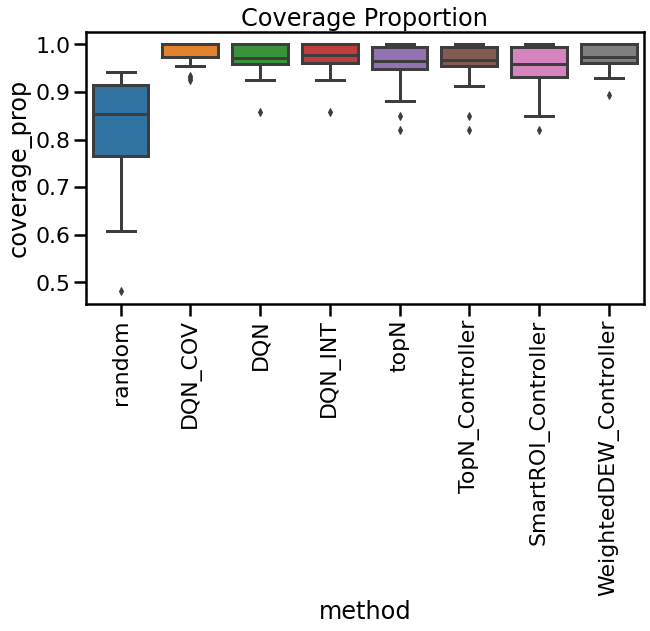

In [22]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

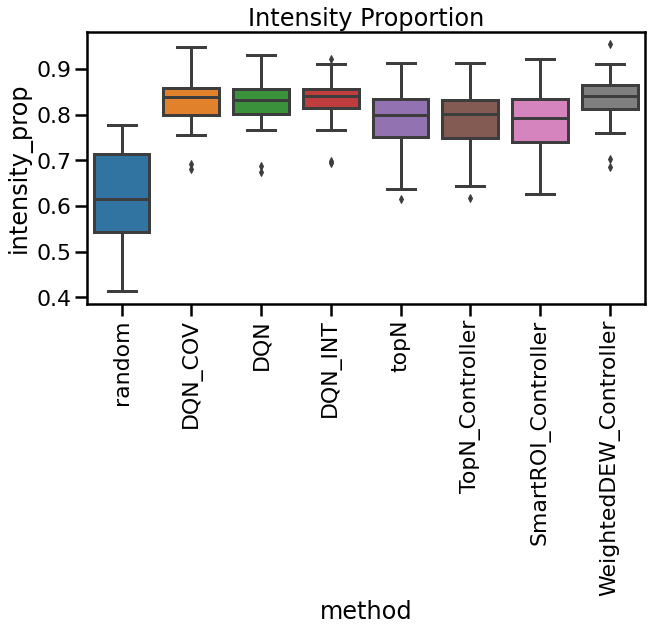

In [23]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

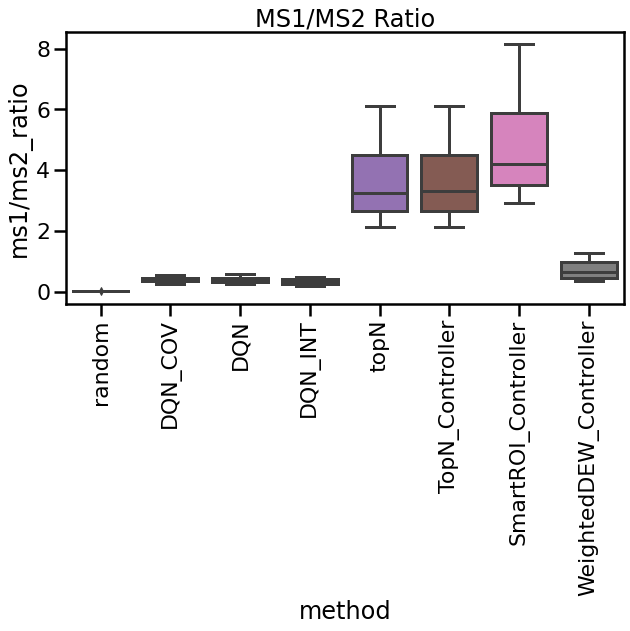

In [24]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Efficiency')

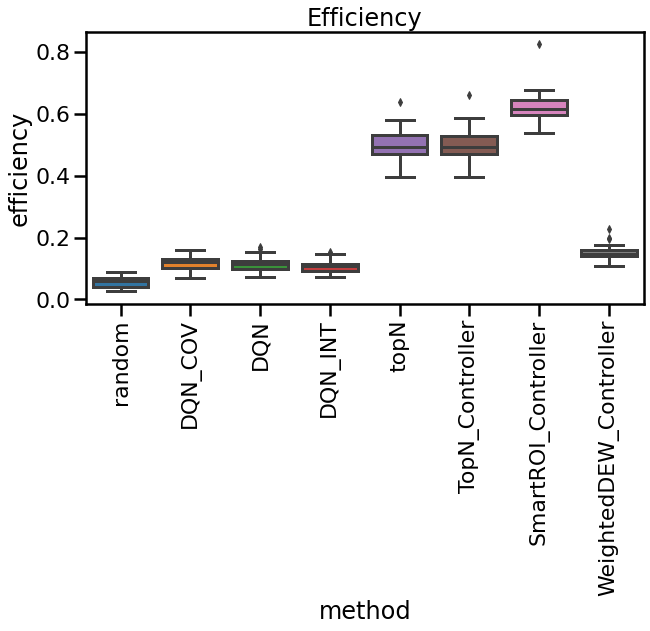

In [25]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='efficiency')
plt.xticks(rotation=90)
plt.title('Efficiency')

Text(0.5, 1.0, 'Precision')

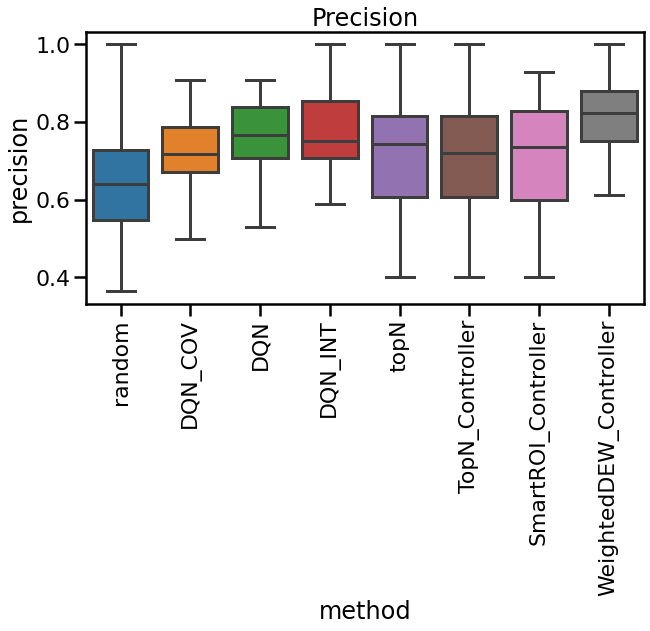

In [26]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

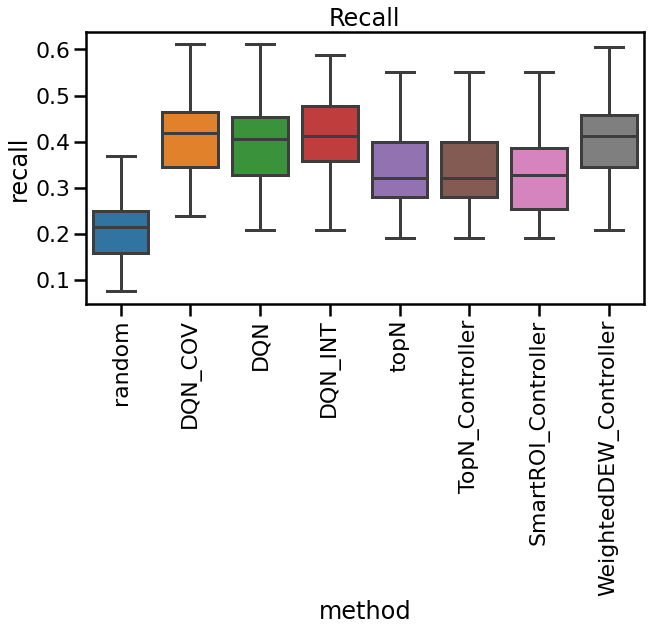

In [27]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

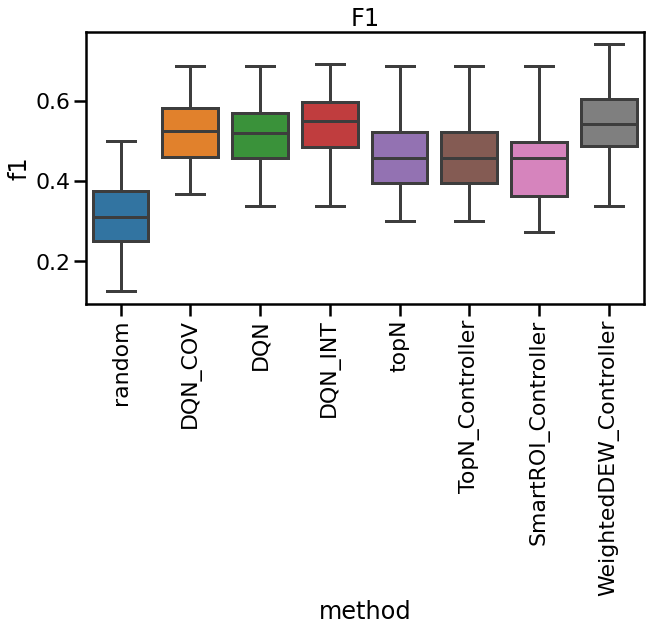

In [28]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')

In [29]:
df.to_pickle('evaluation.p')

### Without 'random'

In [30]:
df = pd.read_pickle('evaluation.p')

In [31]:
new_df = df[df.method != 'random']
new_df.head()

,method,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
30,DQN_COV,1.000,0.844,0.361,0.096,0.667,0.545,0.600
31,DQN_COV,0.955,0.825,0.490,0.083,0.909,0.476,0.625
32,DQN_COV,0.933,0.838,0.431,0.156,0.733,0.268,0.393
33,DQN_COV,0.929,0.692,0.539,0.108,0.727,0.320,0.444
34,DQN_COV,1.000,0.818,0.445,0.075,0.800,0.444,0.571


Text(0.5, 1.0, 'Coverage Proportion')

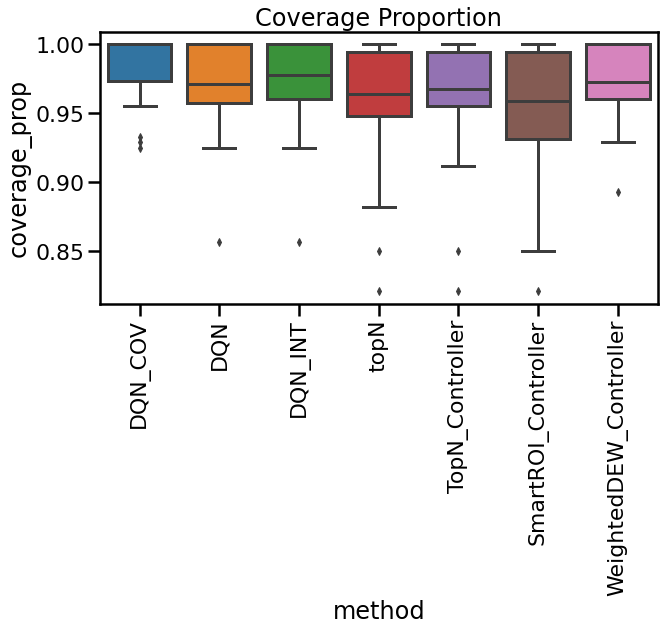

In [32]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

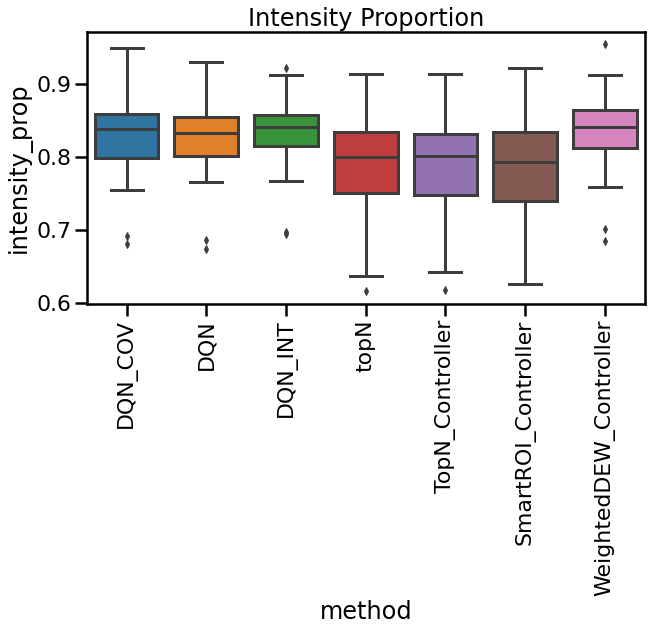

In [33]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

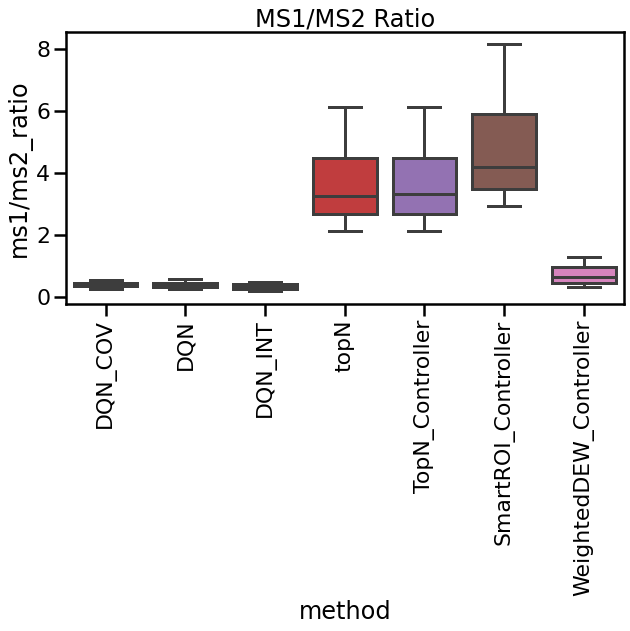

In [34]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Precision')

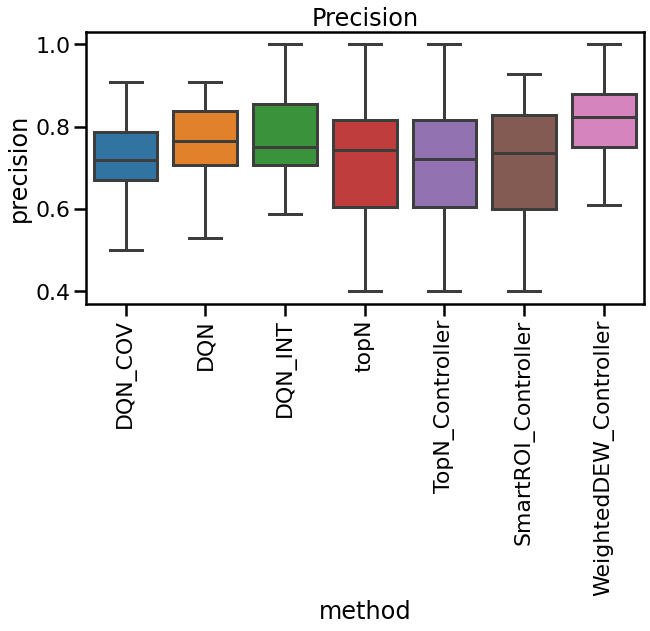

In [35]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

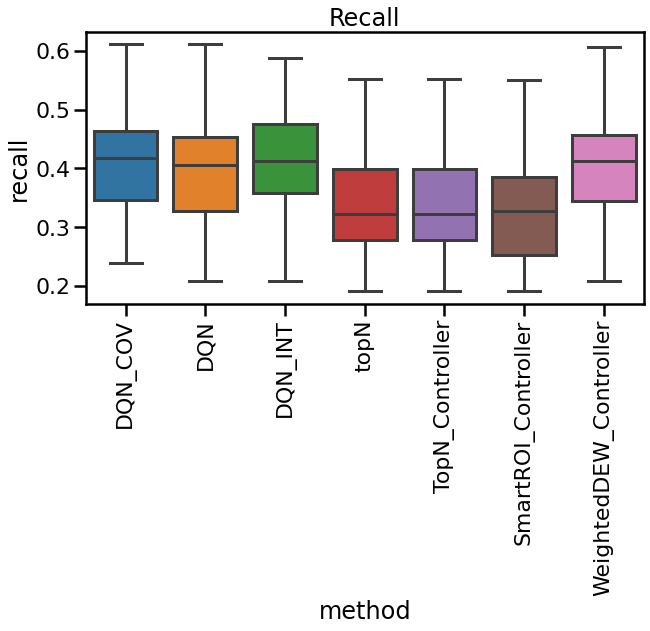

In [36]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

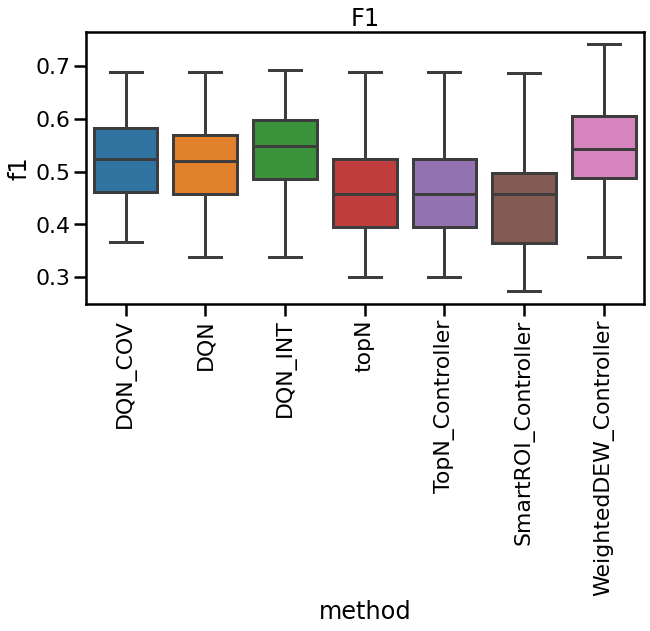

In [37]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')